In [1]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [3]:
#load JH data
confirmed = pd.read_csv('../Zaida/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('../Zaida/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('../Zaida/time_series_covid19_recovered_global.csv')

#turn date columns into rows
confirmed = confirmed.melt(id_vars=['Country/Region','Province/State','Lat','Long'],var_name="Date",value_name="Confirmed")
deaths = deaths.melt(id_vars=['Country/Region','Province/State','Lat','Long'],var_name="Date",value_name="Deaths")
recovered = recovered.melt(id_vars=['Country/Region','Province/State','Lat','Long'],var_name="Date",value_name="Recovered")

In [282]:
#merge dataframes
df = pd.merge(confirmed,deaths,on=['Country/Region','Province/State','Lat','Long','Date'])
df = pd.merge(df,recovered,on=['Country/Region','Province/State','Lat','Long','Date'])
#change date to datetime
df['Date'] = pd.to_datetime(df['Date'])
#sort df
df = df.sort_values(by=['Country/Region','Province/State','Date'])

In [323]:
#train data Netherlands ConfirmedCases
train = df[df['Country/Region'] == 'Netherlands'][df['Province/State'].isnull()]
train = train.drop(['Country/Region', 'Province/State', 'Lat','Long','Date','Deaths','Recovered'],axis=1).values
train = train.astype('float32')

#test data Belgium ConfirmedCases
test = df[df['Country/Region'] == 'Belgium'][df['Province/State'].isnull()]
test = test.drop(['Country/Region', 'Province/State', 'Lat','Long','Date','Deaths','Recovered'],axis=1).values
test = test.astype('float32')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [324]:
scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = scaler.fit_transform(test)
train_scaled = scaler.fit_transform(train)

In [325]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [326]:
look_back = 14
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)
X_train.shape

(92, 14)

In [327]:
# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [328]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 0s - loss: 0.1814
Epoch 2/100
92/92 - 0s - loss: 0.0598
Epoch 3/100
92/92 - 0s - loss: 0.0128
Epoch 4/100
92/92 - 0s - loss: 0.0033
Epoch 5/100
92/92 - 0s - loss: 0.0012
Epoch 6/100
92/92 - 0s - loss: 6.3963e-04
Epoch 7/100
92/92 - 0s - loss: 5.0165e-04
Epoch 8/100
92/92 - 0s - loss: 4.5226e-04
Epoch 9/100
92/92 - 0s - loss: 4.1776e-04
Epoch 10/100
92/92 - 0s - loss: 3.8448e-04
Epoch 11/100
92/92 - 0s - loss: 3.6897e-04
Epoch 12/100
92/92 - 0s - loss: 3.4410e-04
Epoch 13/100
92/92 - 0s - loss: 3.3274e-04
Epoch 14/100
92/92 - 0s - loss: 3.1710e-04
Epoch 15/100
92/92 - 0s - loss: 3.0425e-04
Epoch 16/100
92/92 - 0s - loss: 2.9740e-04
Epoch 17/100
92/92 - 0s - loss: 2.8683e-04
Epoch 18/100
92/92 - 0s - loss: 2.6638e-04
Epoch 19/100
92/92 - 0s - loss: 2.6009e-04
Epoch 20/100
92/92 - 0s - loss: 2.4288e-04
Epoch 21/100
92/92 - 0s - loss: 2.3449e-04
Epoch 22/100
92/92 - 0s - loss: 2.3724e-04
Epoch 23/100
92/92 - 0s - loss: 2.2058e-04
Epoch 24/100
92/92 - 0s - loss: 2.0338e-

In [329]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 173.27 RMSE
Test Score: 241.24 RMSE


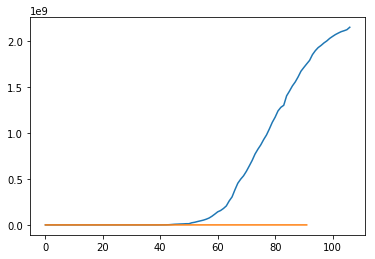

In [330]:
plt.plot(scaler.inverse_transform(test))
plt.plot(testPredict)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in insert will result in an error in the future
  """Entry point for launching an IPython kernel.


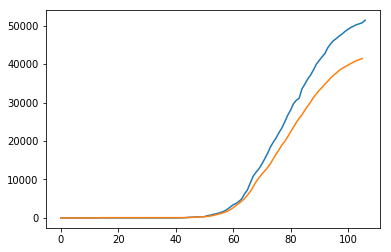

In [331]:
padded = np.insert(testPredict,np.zeros(look_back),0)
plt.plot(test)
plt.plot(padded)
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in insert will result in an error in the future
  """Entry point for launching an IPython kernel.


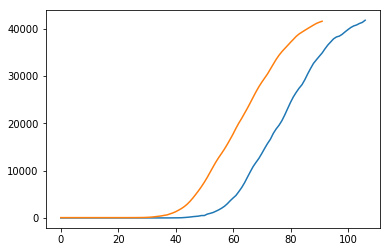

In [332]:
padded = np.insert(testPredict,np.zeros(look_back),0)
plt.plot(train)
plt.plot(trainPredict)
plt.show()

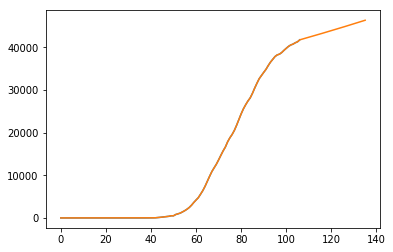

In [435]:
new_preds = []
train_future = train
train_future_scaled = scaler.fit_transform(train_future)
new_input = np.array([train_future_scaled[-look_back:]])
new_input = numpy.reshape(new_input, (new_input.shape[0], 1, new_input.shape[1]))
for i in range(1,30):
    
    new_value = scaler.inverse_transform(model.predict(new_input))[-1][0]
    train_future = np.append(train_future,[[new_value]],axis=0).astype('float32')
    train_future_scaled = scaler.fit_transform(train_future)
    new_preds.append(new_value)
    #new_input = np.array([train_future_scaled[-look_back:]])
    #new_input = numpy.reshape(new_input, (new_input.shape[0], 1, new_input.shape[1]))
    
plt.plot(train)
plt.plot(train_future)
plt.show()

In [424]:
np.append(train_future,[[new_value]],axis=0).astype('float32')

array([[0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [0.000000e+00],
       [1.000000e+00],
       [1.000000e+00],
       [6.000000e+00],
       [1.000000e+01],
       [1.800000e+01],
       [2.400000e+01],
       [3.800000e+01],
       [8.2

In [375]:
np.append

array([0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 1.000000e+00, 6.000000e+00, 1.000000e+01,
       1.800000e+01, 2.400000e+01, 3.800000e+01, 8.200000e+01,
       1.280000e+02, 1.880000e+02, 2.650000e+02, 3.210000e+02,
       3.820000e+02, 5.030000e+02, 5.030000e+02, 8.040000e+02,
       9.590000e+02, 1.135000e+03, 1.413000e+03, 1.705000e+03,
       2.051000e+03, 2.460000e+03, 2.994000e+03, 3.631000e+03,
       4.204000e+03, 4.749000e+03, 5.560000e+03, 6.4120

In [372]:
new_input

array([[[0.87458706],
        [0.8902667 ],
        [0.9059463 ],
        [0.9155216 ],
        [0.9196151 ],
        [0.9288553 ],
        [0.9411596 ],
        [0.9525303 ],
        [0.96318287],
        [0.9712022 ],
        [0.9759659 ],
        [0.98355436],
        [0.9891081 ],
        [1.        ]]], dtype=float32)

In [373]:
numpy.reshape(new_input, (new_input.shape[0], 1, new_input.shape[1]))

array([[[0.87458706, 0.8902667 , 0.9059463 , 0.9155216 , 0.9196151 ,
         0.9288553 , 0.9411596 , 0.9525303 , 0.96318287, 0.9712022 ,
         0.9759659 , 0.98355436, 0.9891081 , 1.        ]]], dtype=float32)

In [378]:
new_input

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])